In [1]:
import json
import os
import requests
import datetime

MILLSECONDS_13_9_START = 1683061200000  # 2023년 05월 03일 수요일
MILLSECONDS_13_10_START = 1684270800000 # 2023년 05월 17일 수요일
MILLSECONDS_13_11_START = 1685566800000 # 2023년 06월 01일 목요일

DIR = r'C:\Users\김성윤\Desktop\data_collector'
API_KEY = 'RGAPI-1a1d24de-0002-4894-85cc-6deaf6ec560e'

def read_json(filename):
    with open(rf'{DIR}\{filename}') as f:
        return json.load(f)
    

def when_does_it_belongs_to(matchid):
    match_info = requests.get(f'https://asia.api.riotgames.com/lol/match/v5/matches/{matchid}?api_key={API_KEY}').json()['info']
    gameCreation = match_info['gameCreation']
    
    if gameCreation < MILLSECONDS_13_10_START:
        gameCreation = 9
    elif gameCreation < MILLSECONDS_13_11_START:
        gameCreation = 10
    else:
        gameCreation = 11
    
    gameDuration = match_info['gameDuration']//60

    is_blue_win = 1 if match_info['teams'][0]['win'] == True else 0
    return [gameCreation for i in range(16)], [gameDuration for i in range(16)] , [is_blue_win for i in range(16)]

In [2]:
game_files = [file for file in os.listdir(DIR) if file.startswith('KR')]
print("게임 갯수 :", len(game_files))

게임 갯수 : 382082


In [3]:
 # 리스트의 각 원소가 순차적으로 누적한다.
def transfomList(original_list):
    original_list = original_list
    new_list = []

    running_sum = 0
    for value in original_list:
        running_sum += value
        new_list.append(running_sum)

    return new_list

# 두 리스트의 차이를 반환한다. ( 블루팀 - 레드팀 )
def subtractList(blue_list1, red_list2):

    result = [a - b for a, b in zip(blue_list1, red_list2)]

    return result

def getMatchData(matchId):
    data = read_json(f'{matchId}')
    #### 블루팀 participantId 1 ~ 5 // 레드팀 participantId 6 ~ 10
    BLUE_IDs = [1,2,3,4,5]
    RED_IDs = [6,7,8,9,10]
    #### 여기는 프레임 인덱스가 N 일때, 실제 그 프레임이 담는 시간대는 N-1 분 0초부터 N-1 분 59초까지임
    #### 따라서 5분부터 15분 0초까지의 정보는 프레임 6분부터 15까지이다.
    frame_10_to_25 = data['info']['frames'][11:27]
    
    is_blue_win = data['info']
    # (해당 시간대에서) 각 팀별 킬 수, 어시스트 수, 누적 대형 오브젝트 처치 수 
    BLUE_KILLS,BLUE_DEATHS,BLUE_ASSISTS,BLUE_OBJECTS,BLUE_GOLDS,BLUE_EXPERIENCES  = [],[],[],[],[],[]   # 참고로 여기서는 각 챔피언들의 어시스트 합
    RED_KILLS,RED_DEATHS,RED_ASSISTS,RED_OBJECTS,RED_GOLDS,RED_EXPERIENCES = [],[],[],[],[],[]

    # patch , game_total_duration , is_blue_win 
    PATCH , LENGTH , IS_BLUE_WIN = when_does_it_belongs_to(matchId.split('.')[0])

    for frame in frame_10_to_25:

        blue_kills,blue_deaths,blue_assists,blue_objects,blue_golds,blue_experiences  = 0,0,0,0,0,0
        red_kills,red_deaths,red_assists,red_objects,red_golds,red_experiences = 0,0,0,0,0,0


        for event in frame['events']:

            if event['type'] == "CHAMPION_KILL":            # KILL, DEATH, ASSIST
                if event['killerId'] in BLUE_IDs:
                    blue_kills += 1
                if event['killerId'] in RED_IDs:
                    red_kills += 1
                if event['victimId'] in BLUE_IDs:
                    blue_deaths += 1
                if event['victimId'] in RED_IDs:
                    red_deaths += 1
                if event.get("assistingParticipantIds") != None:
                    for assistId in event.get("assistingParticipantIds"):
                        if assistId in BLUE_IDs:
                            blue_assists += 1
                        if assistId in RED_IDs:
                            red_assists += 1

            if event['type'] == "ELITE_MONSTER_KILL":       # ELITE MONSTER KILL
                if event['killerTeamId'] == 100:
                    blue_objects += 1
                else:
                    red_objects += 1
        

        for index in frame['participantFrames']:
            if int(index)  <= 5:
                
                blue_golds += frame['participantFrames'][index]['totalGold']
                blue_experiences += frame['participantFrames'][str(index)]['xp']
            else:
                red_golds += frame['participantFrames'][index]['totalGold']
                red_experiences += frame['participantFrames'][index]['xp']

        

        BLUE_KILLS.append(blue_kills)
        BLUE_DEATHS.append(blue_deaths)
        BLUE_ASSISTS.append(blue_assists)
        BLUE_OBJECTS.append(blue_objects)
        BLUE_GOLDS.append(blue_golds)
        BLUE_EXPERIENCES.append(blue_experiences)

        # # 누적 횟수로 전환
        
        # BLUE_GOLDS = transfomList(BLUE_GOLDS)
        # BLUE_EXPERIENCES = transfomList(BLUE_EXPERIENCES)

        RED_KILLS.append(red_kills)
        RED_DEATHS.append(red_deaths)
        RED_ASSISTS.append(red_assists)
        RED_OBJECTS.append(red_objects)
        RED_GOLDS.append(red_golds)
        RED_EXPERIENCES.append(red_experiences)

        # # 누적 횟수로 전환
        
        # RED_GOLDS = transfomList(RED_GOLDS)
        # RED_EXPERIENCES = transfomList(RED_EXPERIENCES)

    BLUE_KILLS = transfomList(BLUE_KILLS)
    BLUE_DEATHS = transfomList(BLUE_DEATHS)
    BLUE_ASSISTS = transfomList(BLUE_ASSISTS)
    BLUE_OBJECTS = transfomList(BLUE_OBJECTS)

    RED_KILLS = transfomList(RED_KILLS)
    RED_DEATHS = transfomList(RED_DEATHS)
    RED_ASSISTS = transfomList(RED_ASSISTS)
    RED_OBJECTS = transfomList(RED_OBJECTS)
        # 팀 차이 계산

    '''DIFF_KILLS = subtractList(BLUE_KILLS,RED_KILLS)
        DIFF_DEATHS = subtractList(BLUE_DEATHS,RED_DEATHS)
        DIFF_ASSISTS = subtractList(BLUE_ASSISTS,RED_ASSISTS)
        DIFF_OBJECTS = subtractList(BLUE_OBJECTS,RED_OBJECTS)
        DIFF_GOLDS = subtractList(BLUE_GOLDS,RED_GOLDS)
        DIFF_EXPERIENCES = subtractList(BLUE_EXPERIENCES,RED_EXPERIENCES)'''

            #위 순서대로 리스트 병합
    
    allData = []
    allData.append([matchId for i in range(16)])
    allData.append(list(range(10,26)))
    allData.append(BLUE_KILLS) , allData.append(BLUE_DEATHS) , allData.append(BLUE_ASSISTS) , allData.append(BLUE_OBJECTS) , allData.append(BLUE_GOLDS) , allData.append(BLUE_EXPERIENCES)
    allData.append(RED_KILLS) , allData.append(RED_DEATHS) , allData.append(RED_ASSISTS) , allData.append(RED_OBJECTS) , allData.append(RED_GOLDS) , allData.append(RED_EXPERIENCES) , allData.append(PATCH), allData.append(LENGTH), allData.append(IS_BLUE_WIN)

    
    return allData

import csv
from tqdm import tqdm

def writeCSVfile(matchIds): #위에서 추출한 정보들을 csv 파일로 저장한다. 모든 matchIds들에 대해서 진행.
        
        features = ['matchID']

        features.append('해당시각')

        features.append('블루킬')

        features.append('블루데스')

        features.append('블루어시')
    
        features.append('블루오브젝')

        features.append('블루골드')

        features.append('블루경험치')

    
        features.append('레드킬')
    
        features.append('레드데스')
    
        features.append('레드어시')
    
        features.append('레드오브젝')

        features.append('레드골드')

        features.append('레드경험치')


        features.append('패치')

        features.append('게임길이')

        features.append('블루승리여부')

        f = open(rf'{DIR}\MASTER_TIMELINE_DATA.csv','a', newline='')
        wr = csv.writer(f)
        wr.writerow(features)
        
        for matchId in tqdm(matchIds):
            try:
                rows = getMatchData(matchId)
                cols = list(map(list, zip(*rows)))
                wr.writerows(cols)
            except:
                pass

        f.close()

        print('csv write complete')

In [4]:
writeCSVfile(game_files)

100%|██████████| 382082/382082 [37:36:56<00:00,  2.82it/s]     

csv write complete


In [121]:
import pandas as pd

df = pd.read_csv(rf'{DIR}\MASTER_TIMELINE_DATA.csv' , encoding='ANSI')

In [122]:
df = df[df['게임길이']<30]

In [123]:
df.describe()

,해당시각,블루킬,블루데스,블루어시,블루오브젝,블루골드,블루경험치,레드킬,레드데스,레드어시,레드오브젝,레드골드,레드경험치,패치,게임길이,블루승리여부
count,3.469045e+06,3.469045e+06,3.469045e+06,3.469045e+06,3.469045e+06,3.469045e+06,3.469045e+06,3.469045e+06,3.469045e+06,3.469045e+06,3.469045e+06,3.469045e+06,3.469045e+06,3.469045e+06,3.469045e+06,3.469045e+06
mean,1.599123e+01,9.731066e+00,9.804722e+00,1.623751e+01,8.448769e-01,3.744476e+04,4.257680e+04,9.770885e+00,9.764682e+00,1.623448e+01,8.896552e-01,3.750214e+04,4.272949e+04,9.236540e+00,2.273230e+01,4.910738e-01
std,4.231092e+00,8.227768e+00,8.236173e+00,1.762038e+01,1.148097e+00,1.438558e+04,2.124374e+04,8.211315e+00,8.251789e+00,1.752174e+01,1.186231e+00,1.438244e+04,2.119874e+04,4.249575e-01,4.237226e+00,4.999204e-01
min,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.517000e+03,3.022000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.214000e+03,2.274000e+03,9.000000e+00,1.000000e+01,0.000000e+00
25%,1.200000e+01,4.000000e+00,4.000000e+00,4.000000e+00,0.000000e+00,2.598000e+04,2.726300e+04,4.000000e+00,4.000000e+00,4.000000e+00,0.000000e+00,2.601200e+04,2.739000e+04,9.000000e+00,2.000000e+01,0.000000e+00
50%,1.500000e+01,8.000000e+00,8.000000e+00,1.000000e+01,0.000000e+00,3.517400e+04,3.737000e+04,8.000000e+00,8.000000e+00,1.000000e+01,0.000000e+00,3.527200e+04,3.760400e+04,9.000000e+00,2.300000e+01,0.000000e+00
75%,1.900000e+01,1.400000e+01,1.400000e+01,2.200000e+01,1.000000e+00,4.570300e+04,5.071900e+04,1.400000e+01,1.400000e+01,2.200000e+01,1.000000e+00,4.583600e+04,5.104800e+04,9.000000e+00,2.600000e+01,1.000000e+00
max,2.500000e+01,6.900000e+01,7.400000e+01,1.780000e+02,7.000000e+00,1.076660e+05,1.961610e+05,7.400000e+01,6.900000e+01,1.700000e+02,7.000000e+00,1.095970e+05,2.110660e+05,1.000000e+01,2.900000e+01,1.000000e+00


In [125]:
import numpy as np

df['킬 차이'] = df['블루킬'] - df['레드킬']
df['어시스트 차이'] = df['블루어시'] - df['레드어시']
df['데스 차이'] = df['블루데스'] - df['레드데스']
df['kda 블루'] = ((df['블루킬'] + df['블루어시'])/(df['블루데스']+1)) #.replace(np.inf, df['블루킬'] + df['블루어시'])
df['kda 레드'] = ((df['레드킬'] + df['레드어시'])/(df['레드데스']+1)) #.replace(np.inf, df['레드킬'] + df['레드어시'])

df['골드 차이'] = df['블루골드'] - df['레드골드']
df['경험치 차이'] = df['블루경험치'] - df['레드경험치']
df['오브젝 차이'] = df['블루오브젝'] - df['레드오브젝']
df['게임 진행률'] = df['해당시각']/df['게임길이']

df['패치'] = df['패치'].astype('category')

df = pd.get_dummies(df, columns=['패치'])

In [126]:
df = df.dropna()

In [127]:
df.isna().sum()

matchID    0
해당시각       0
블루킬        0
블루데스       0
블루어시       0
블루오브젝      0
블루골드       0
블루경험치      0
레드킬        0
레드데스       0
레드어시       0
레드오브젝      0
레드골드       0
레드경험치      0
게임길이       0
블루승리여부     0
킬 차이       0
어시스트 차이    0
데스 차이      0
kda 블루     0
kda 레드     0
골드 차이      0
경험치 차이     0
오브젝 차이     0
게임 진행률     0
패치_9       0
패치_10      0
dtype: int64

In [142]:
df

,matchID,해당시각,블루킬,블루데스,블루어시,블루오브젝,블루골드,블루경험치,레드킬,레드데스,...,어시스트 차이,데스 차이,kda 블루,kda 레드,골드 차이,경험치 차이,오브젝 차이,게임 진행률,패치_9,패치_10
602,KR_5564970910.json,10,0,0,0,0,18322,19932,0,0,...,0,0,0.000000,0.000000,672,296,0,0.370370,True,False
603,KR_5564970910.json,11,0,3,0,0,19965,21686,3,0,...,-5,3,0.000000,8.000000,-782,-1573,0,0.407407,True,False
604,KR_5564970910.json,12,0,3,0,0,21336,23542,3,0,...,-5,3,0.000000,8.000000,-739,-1192,0,0.444444,True,False
605,KR_5564970910.json,13,0,3,0,0,23092,25713,3,0,...,-5,3,0.000000,8.000000,-1021,-1517,0,0.481481,True,False
606,KR_5564970910.json,14,2,7,3,0,25606,27908,7,2,...,-14,5,0.625000,8.000000,-1379,-2138,-1,0.518519,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4620810,KR_6510489016.json,18,21,26,54,0,63690,86399,26,21,...,-7,5,2.777778,3.954545,-5982,-5287,0,0.818182,False,True
4620811,KR_6510489016.json,19,24,28,55,0,67716,96249,28,25,...,-10,3,2.724138,3.576923,-5275,-1320,0,0.863636,False,True
4620812,KR_6510489016.json,20,25,31,58,0,70182,100345,31,26,...,-12,5,2.593750,3.740741,-6172,-4150,0,0.909091,False,True
4620813,KR_6510489016.json,21,28,36,62,0,73227,105743,36,29,...,-18,7,2.432432,3.866667,-7110,-8140,0,0.954545,False,True


In [145]:
key_dataframe = df[['matchID','해당시각']]

In [146]:
key_dataframe.rename(columns={'해당시각': '해당시각정수형'}, inplace=True)

C:\Users\김성윤\AppData\Local\Temp\ipykernel_16608\98791338.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key_dataframe.rename(columns={'해당시각': '해당시각정수형'}, inplace=True)


In [149]:
key_dataframe.reset_index(drop=True, inplace=True)

In [150]:
key_dataframe

,matchID,해당시각정수형
0,KR_5564970910.json,10
1,KR_5564970910.json,11
2,KR_5564970910.json,12
3,KR_5564970910.json,13
4,KR_5564970910.json,14
...,...,...
3469040,KR_6510489016.json,18
3469041,KR_6510489016.json,19
3469042,KR_6510489016.json,20
3469043,KR_6510489016.json,21


In [128]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


labels = df['블루승리여부']
data = df.drop('블루승리여부', axis=1)
data = data.drop('matchID', axis=1)


scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [157]:
labels

602        1
603        1
604        1
605        1
606        1
          ..
4620810    0
4620811    0
4620812    0
4620813    0
4620814    0
Name: 블루승리여부, Length: 3469045, dtype: int64

In [158]:
label_dataframe = pd.DataFrame(labels)

In [159]:
label_dataframe

,블루승리여부
602,1
603,1
604,1
605,1
606,1
...,...
4620810,0
4620811,0
4620812,0
4620813,0


In [160]:
label_dataframe.reset_index(drop=True, inplace=True)
label_dataframe

,블루승리여부
0,1
1,1
2,1
3,1
4,1
...,...
3469040,0
3469041,0
3469042,0
3469043,0


In [140]:
data.to_csv(rf'{DIR}\MASTER_TIMELINE_DATA.csv')

In [500]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_normalized, labels, test_size=0.2, random_state=42)

# Define a simple sequential model
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=1, validation_split=0.2)

# Evaluate the model on the test data using `evaluate`
print("\nEvaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 32)                832       
                                                                 
 dense_34 (Dense)            (None, 64)                2112      
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________
69381/69381 [==============================] - 235s 3ms/step - loss: 0.3032 - accuracy: 0.8526 - val_loss: 0.2982 - val_accuracy: 0.8554

Evaluate on test data
5421/5421 [==============================] - 9s 2ms/step - loss: 0.2981 - accuracy: 0.8558
test loss, test acc: [0.2980923652648926, 0.8557758927345276]


In [501]:
y_pred = model.predict(X_test)

21682/21682 [==============================] - 15s 700us/step


In [503]:
y_pred = np.where(y_pred > 0.5, 1, 0)

In [504]:
from sklearn import metrics

# assuming y_true and y_pred are your data
# y_true = [...]
# y_pred = model.predict(X_test)

# Print the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred, digits=3))


[[297793  55314]
 [ 44750 295952]]
              precision    recall  f1-score   support

           0      0.869     0.843     0.856    353107
           1      0.843     0.869     0.855    340702

    accuracy                          0.856    693809
   macro avg      0.856     0.856     0.856    693809
weighted avg      0.856     0.856     0.856    693809



In [ ]:
model.score()

In [135]:
data_normalized

,해당시각,블루킬,블루데스,블루어시,블루오브젝,블루골드,블루경험치,레드킬,레드데스,레드어시,...,어시스트 차이,데스 차이,kda 블루,kda 레드,골드 차이,경험치 차이,오브젝 차이,게임 진행률,패치_9,패치_10
0,0.000000,0.000000,0.000000,0.000000,0.0,0.089711,0.087554,0.000000,0.000000,0.000000,...,0.505976,0.569767,0.000000,0.000000,0.437114,0.546524,0.500000,0.038986,1.0,0.0
1,0.066667,0.000000,0.040541,0.000000,0.0,0.106450,0.096635,0.040541,0.000000,0.029412,...,0.486056,0.604651,0.000000,0.097561,0.412616,0.517355,0.500000,0.095517,1.0,0.0
2,0.133333,0.000000,0.040541,0.000000,0.0,0.120419,0.106245,0.040541,0.000000,0.029412,...,0.486056,0.604651,0.000000,0.097561,0.413341,0.523301,0.500000,0.152047,1.0,0.0
3,0.200000,0.000000,0.040541,0.000000,0.0,0.138310,0.117485,0.040541,0.000000,0.029412,...,0.486056,0.604651,0.000000,0.097561,0.408589,0.518229,0.500000,0.208577,1.0,0.0
4,0.266667,0.028986,0.094595,0.016854,0.0,0.163924,0.128850,0.094595,0.028986,0.100000,...,0.450199,0.627907,0.008333,0.097561,0.402558,0.508537,0.428571,0.265107,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3469040,0.533333,0.304348,0.351351,0.303371,0.0,0.551947,0.431694,0.351351,0.304348,0.358824,...,0.478088,0.627907,0.037037,0.048226,0.325005,0.459391,0.500000,0.722488,0.0,1.0
3469041,0.600000,0.347826,0.378378,0.308989,0.0,0.592966,0.482694,0.378378,0.362319,0.382353,...,0.466135,0.604651,0.036322,0.043621,0.336916,0.521303,0.500000,0.791866,0.0,1.0
3469042,0.666667,0.362319,0.418919,0.325843,0.0,0.618091,0.503901,0.418919,0.376812,0.411765,...,0.458167,0.627907,0.034583,0.045619,0.321803,0.477136,0.500000,0.861244,0.0,1.0
3469043,0.733333,0.405797,0.486486,0.348315,0.0,0.649115,0.531850,0.486486,0.420290,0.470588,...,0.434263,0.651163,0.032432,0.047154,0.306000,0.414864,0.500000,0.930622,0.0,1.0


In [133]:
results = model.predict(data_normalized)

108408/108408 [==============================] - 77s 710us/step


In [134]:
len(results)

3469045

In [141]:
win_prob_dataframe = pd.DataFrame(results, columns=['승리확률'])

In [161]:
data_normalized.reset_index(drop=True, inplace=True)
data_normalized


,해당시각,블루킬,블루데스,블루어시,블루오브젝,블루골드,블루경험치,레드킬,레드데스,레드어시,...,어시스트 차이,데스 차이,kda 블루,kda 레드,골드 차이,경험치 차이,오브젝 차이,게임 진행률,패치_9,패치_10
0,0.000000,0.000000,0.000000,0.000000,0.0,0.089711,0.087554,0.000000,0.000000,0.000000,...,0.505976,0.569767,0.000000,0.000000,0.437114,0.546524,0.500000,0.038986,1.0,0.0
1,0.066667,0.000000,0.040541,0.000000,0.0,0.106450,0.096635,0.040541,0.000000,0.029412,...,0.486056,0.604651,0.000000,0.097561,0.412616,0.517355,0.500000,0.095517,1.0,0.0
2,0.133333,0.000000,0.040541,0.000000,0.0,0.120419,0.106245,0.040541,0.000000,0.029412,...,0.486056,0.604651,0.000000,0.097561,0.413341,0.523301,0.500000,0.152047,1.0,0.0
3,0.200000,0.000000,0.040541,0.000000,0.0,0.138310,0.117485,0.040541,0.000000,0.029412,...,0.486056,0.604651,0.000000,0.097561,0.408589,0.518229,0.500000,0.208577,1.0,0.0
4,0.266667,0.028986,0.094595,0.016854,0.0,0.163924,0.128850,0.094595,0.028986,0.100000,...,0.450199,0.627907,0.008333,0.097561,0.402558,0.508537,0.428571,0.265107,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3469040,0.533333,0.304348,0.351351,0.303371,0.0,0.551947,0.431694,0.351351,0.304348,0.358824,...,0.478088,0.627907,0.037037,0.048226,0.325005,0.459391,0.500000,0.722488,0.0,1.0
3469041,0.600000,0.347826,0.378378,0.308989,0.0,0.592966,0.482694,0.378378,0.362319,0.382353,...,0.466135,0.604651,0.036322,0.043621,0.336916,0.521303,0.500000,0.791866,0.0,1.0
3469042,0.666667,0.362319,0.418919,0.325843,0.0,0.618091,0.503901,0.418919,0.376812,0.411765,...,0.458167,0.627907,0.034583,0.045619,0.321803,0.477136,0.500000,0.861244,0.0,1.0
3469043,0.733333,0.405797,0.486486,0.348315,0.0,0.649115,0.531850,0.486486,0.420290,0.470588,...,0.434263,0.651163,0.032432,0.047154,0.306000,0.414864,0.500000,0.930622,0.0,1.0


In [162]:
win_prob_dataframe.reset_index(drop=True, inplace=True)
win_prob_dataframe

,승리확률
0,0.569761
1,0.367816
2,0.371240
3,0.339572
4,0.249351
...,...
3469040,0.236981
3469041,0.311164
3469042,0.182071
3469043,0.073333


In [163]:
new_df = pd.concat([key_dataframe, data_normalized, label_dataframe, win_prob_dataframe], axis=1)
new_df

,matchID,해당시각정수형,해당시각,블루킬,블루데스,블루어시,블루오브젝,블루골드,블루경험치,레드킬,...,kda 블루,kda 레드,골드 차이,경험치 차이,오브젝 차이,게임 진행률,패치_9,패치_10,블루승리여부,승리확률
0,KR_5564970910.json,10,0.000000,0.000000,0.000000,0.000000,0.0,0.089711,0.087554,0.000000,...,0.000000,0.000000,0.437114,0.546524,0.500000,0.038986,1.0,0.0,1,0.569761
1,KR_5564970910.json,11,0.066667,0.000000,0.040541,0.000000,0.0,0.106450,0.096635,0.040541,...,0.000000,0.097561,0.412616,0.517355,0.500000,0.095517,1.0,0.0,1,0.367816
2,KR_5564970910.json,12,0.133333,0.000000,0.040541,0.000000,0.0,0.120419,0.106245,0.040541,...,0.000000,0.097561,0.413341,0.523301,0.500000,0.152047,1.0,0.0,1,0.371240
3,KR_5564970910.json,13,0.200000,0.000000,0.040541,0.000000,0.0,0.138310,0.117485,0.040541,...,0.000000,0.097561,0.408589,0.518229,0.500000,0.208577,1.0,0.0,1,0.339572
4,KR_5564970910.json,14,0.266667,0.028986,0.094595,0.016854,0.0,0.163924,0.128850,0.094595,...,0.008333,0.097561,0.402558,0.508537,0.428571,0.265107,1.0,0.0,1,0.249351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3469040,KR_6510489016.json,18,0.533333,0.304348,0.351351,0.303371,0.0,0.551947,0.431694,0.351351,...,0.037037,0.048226,0.325005,0.459391,0.500000,0.722488,0.0,1.0,0,0.236981
3469041,KR_6510489016.json,19,0.600000,0.347826,0.378378,0.308989,0.0,0.592966,0.482694,0.378378,...,0.036322,0.043621,0.336916,0.521303,0.500000,0.791866,0.0,1.0,0,0.311164
3469042,KR_6510489016.json,20,0.666667,0.362319,0.418919,0.325843,0.0,0.618091,0.503901,0.418919,...,0.034583,0.045619,0.321803,0.477136,0.500000,0.861244,0.0,1.0,0,0.182071
3469043,KR_6510489016.json,21,0.733333,0.405797,0.486486,0.348315,0.0,0.649115,0.531850,0.486486,...,0.032432,0.047154,0.306000,0.414864,0.500000,0.930622,0.0,1.0,0,0.073333


In [ ]:
new_df

In [164]:
new_df.to_csv(rf'{DIR}\MASTER_TIMELINE_DATA_PREPROCESSED.csv' , encoding='ANSI')

In [171]:
read_data = pd.read_csv(rf'{DIR}\MASTER_TIMELINE_DATA_PREPROCESSED.csv', encoding='ANSI')

In [172]:
filtered_df = read_data   #[(read_data['블루승리여부'] == 1) & (read_data['승리확률'] > 0.5)]
filtered_df

,Unnamed: 0,matchID,해당시각정수형,해당시각,블루킬,블루데스,블루어시,블루오브젝,블루골드,블루경험치,...,kda 블루,kda 레드,골드 차이,경험치 차이,오브젝 차이,게임 진행률,패치_9,패치_10,블루승리여부,승리확률
0,0,KR_5564970910.json,10,0.000000,0.000000,0.000000,0.000000,0.0,0.089711,0.087554,...,0.000000,0.000000,0.437114,0.546524,0.500000,0.038986,1.0,0.0,1,0.569761
1,1,KR_5564970910.json,11,0.066667,0.000000,0.040541,0.000000,0.0,0.106450,0.096635,...,0.000000,0.097561,0.412616,0.517355,0.500000,0.095517,1.0,0.0,1,0.367816
2,2,KR_5564970910.json,12,0.133333,0.000000,0.040541,0.000000,0.0,0.120419,0.106245,...,0.000000,0.097561,0.413341,0.523301,0.500000,0.152047,1.0,0.0,1,0.371240
3,3,KR_5564970910.json,13,0.200000,0.000000,0.040541,0.000000,0.0,0.138310,0.117485,...,0.000000,0.097561,0.408589,0.518229,0.500000,0.208577,1.0,0.0,1,0.339572
4,4,KR_5564970910.json,14,0.266667,0.028986,0.094595,0.016854,0.0,0.163924,0.128850,...,0.008333,0.097561,0.402558,0.508537,0.428571,0.265107,1.0,0.0,1,0.249351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3469040,3469040,KR_6510489016.json,18,0.533333,0.304348,0.351351,0.303371,0.0,0.551947,0.431694,...,0.037037,0.048226,0.325005,0.459391,0.500000,0.722488,0.0,1.0,0,0.236981
3469041,3469041,KR_6510489016.json,19,0.600000,0.347826,0.378378,0.308989,0.0,0.592966,0.482694,...,0.036322,0.043621,0.336916,0.521303,0.500000,0.791866,0.0,1.0,0,0.311164
3469042,3469042,KR_6510489016.json,20,0.666667,0.362319,0.418919,0.325843,0.0,0.618091,0.503901,...,0.034583,0.045619,0.321803,0.477136,0.500000,0.861244,0.0,1.0,0,0.182071
3469043,3469043,KR_6510489016.json,21,0.733333,0.405797,0.486486,0.348315,0.0,0.649115,0.531850,...,0.032432,0.047154,0.306000,0.414864,0.500000,0.930622,0.0,1.0,0,0.073333


In [464]:
filtered_df.columns

Index(['Unnamed: 0', 'matchID', '해당시각정수형', '해당시각', '블루킬', '블루데스', '블루어시',
       '블루오브젝', '블루골드', '블루경험치', '레드킬', '레드데스', '레드어시', '레드오브젝', '레드골드',
       '레드경험치', '게임길이', '킬 차이', '어시스트 차이', '데스 차이', 'kda 블루', 'kda 레드',
       '골드 차이', '경험치 차이', '오브젝 차이', '게임 진행률', '패치_9', '패치_10', '블루승리여부',
       '승리확률'],
      dtype='object')

In [469]:
corr = filtered_df[['킬 차이', '어시스트 차이', '데스 차이', 'kda 블루', 'kda 레드',
       '골드 차이', '경험치 차이', '오브젝 차이', '게임 진행률', '블루승리여부']].corr()

In [474]:
import matplotlib
print(matplotlib.get_cachedir())

C:\Users\김성윤\.matplotlib


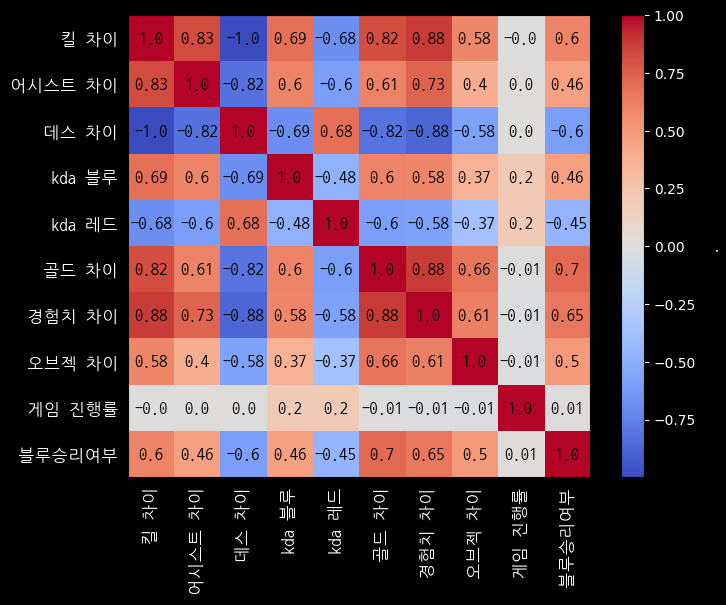

In [499]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm


# Create some data
data = corr

# Specify the font path
path = r'C:\Users\김성윤\Desktop\NanumGothicCoding-2.5\NanumGothicCoding.ttf'
fontprop = fm.FontProperties(fname=path, size=12)

# Set column names
columns = ['킬 차이', '어시스트 차이', '데스 차이', 'kda 블루', 'kda 레드','골드 차이', '경험치 차이', '오브젝 차이', '게임 진행률', '블루승리여부']

# Create heatmap
plt.figure(figsize=(8,6))

plt.rcParams['figure.facecolor'] = 'black'
plt.imshow(data, cmap='coolwarm', interpolation='nearest')

# Set the tick locations and labels
plt.xticks(np.arange(len(columns)), columns, rotation=90, fontproperties=fontprop, color='white')
plt.yticks(np.arange(len(columns)), columns, fontproperties=fontprop, color='white')


# Add values on cells
for i in range(len(columns)):
    for j in range(len(columns)):
        text = plt.text(j, i, round(data.iloc[i, j], 2),
                       ha="center", va="center", color="k", fontproperties=fontprop)

# Add a colorbar and set the label to some Korean text
cbar = plt.colorbar()
cbar.set_label('.', fontproperties=fontprop, color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

plt.show()

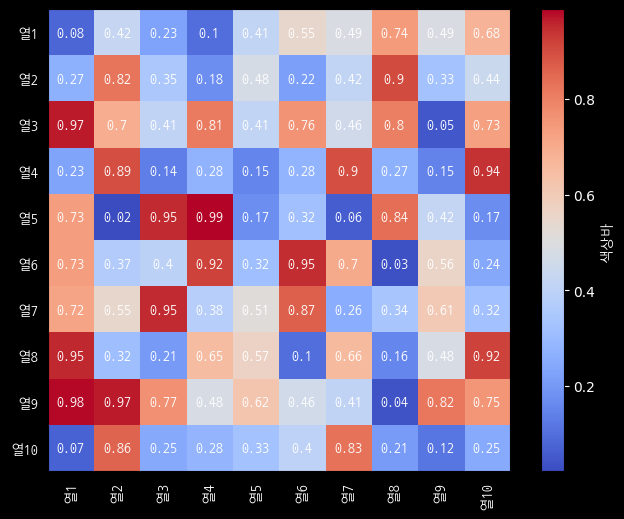

In [494]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

# Create some data
data = np.random.rand(10,10)

# Specify the font path
path = r'C:\Users\김성윤\Desktop\NanumGothicCoding-2.5\NanumGothicCoding.ttf'
fontprop = fm.FontProperties(fname=path, size=10)

# Set column names
columns = ['열1', '열2', '열3', '열4', '열5', '열6', '열7', '열8', '열9', '열10']

# Create heatmap
plt.figure(figsize=(8,6))

# Change the figure facecolor to black
plt.rcParams['figure.facecolor'] = 'black'

plt.imshow(data, cmap='coolwarm', interpolation='nearest')

# Set the tick locations and labels
plt.xticks(np.arange(len(columns)), columns, rotation=90, fontproperties=fontprop, color='white')
plt.yticks(np.arange(len(columns)), columns, fontproperties=fontprop, color='white')

# Add values on cells
for i in range(len(columns)):
    for j in range(len(columns)):
        text = plt.text(j, i, round(data[i, j], 2),
                       ha="center", va="center", color="w", fontproperties=fontprop)

# Add a colorbar and set the label to some Korean text
cbar = plt.colorbar()
cbar.set_label('색상바', fontproperties=fontprop, color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

plt.show()


AttributeError: module 'matplotlib.pyplot' has no attribute 'heatmap'

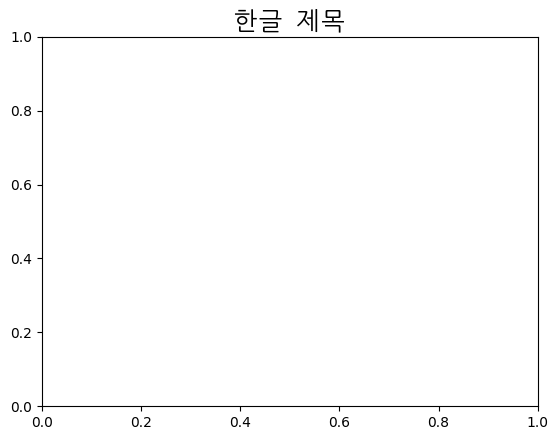

<Figure size 1000x800 with 0 Axes>

In [480]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

path = r'C:\Users\김성윤\Desktop\NanumGothicCoding-2.5\NanumGothicCoding.ttf'
fontprop = fm.FontProperties(fname=path, size=18)

plt.title('한글 제목', fontproperties=fontprop)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns, 
            annot=True,
            cmap=sns.diverging_palette(220, 20, as_cmap=True))

plt.title('Correlation Heatmap', fontsize=16)
plt.show()

In [477]:
!pip install seaborn

!apt -qq -y install fonts-nanum > /dev/null
import matplotlib.font_manager as fm
fontpath = r'C:\Users\김성윤\Desktop\NanumGothicCoding-2.5\NanumGothicCoding.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()

import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumBarunGothic') 
sns.set(font="NanumBarunGothic")

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns, 
            annot=True,
            cmap=sns.diverging_palette(220, 20, as_cmap=True))

plt.title('Correlation Heatmap', fontsize=16)
plt.show()

������ ��θ� ã�� �� �����ϴ�.


AttributeError: module 'matplotlib.font_manager' has no attribute '_rebuild'

In [ ]:
filtered_df[[]]

In [213]:
def derive_data(matchid,timestamp):
    p1 = filtered_df[(filtered_df['matchID'] == matchid) & (filtered_df['해당시각정수형'] == (timestamp-1))].iloc[0]['승리확률']
    p2 = filtered_df[(filtered_df['matchID'] == matchid) & (filtered_df['해당시각정수형'] == (timestamp))].iloc[0]['승리확률']
    return p2 - p1

In [201]:
derive_data('KR_5564970910.json' , 11)

0.56976074
0.36781624


-0.20194449999999997

In [210]:
read_json('KR_6510489016.json')['info']['frames'][11]['participantFrames']['1']['totalGold']

7044

In [401]:
def get_match_gold_data(matchid,timestamp):

    # 11분에서의 승률 변화는 11분에서의 승률 - 10분에서의 승률 임.
    # 11분 : idx 12 - 11 임
    TOP_GOLD,JUG_GOLD,MID_GOLD,ADC_GOLD,SUP_GOLD,PROB_GAP = [],[],[],[],[],0
    TOP_GOLD_GAP,JUG_GOLD_GAP,MID_GOLD_GAP,ADC_GOLD_GAP,SUP_GOLD_GAP = [],[],[],[],[]

    frames = read_json(matchid)['info']['frames'][timestamp:timestamp+2]
    for frame in frames:
        TOP_GOLD.append(frame['participantFrames']['1']['totalGold'])
        JUG_GOLD.append(frame['participantFrames']['2']['totalGold'])
        MID_GOLD.append(frame['participantFrames']['3']['totalGold'])
        ADC_GOLD.append(frame['participantFrames']['4']['totalGold'])
        SUP_GOLD.append(frame['participantFrames']['5']['totalGold'])

        TOP_GOLD_GAP.append(frame['participantFrames']['1']['totalGold'] - frame['participantFrames']['6']['totalGold'])
        JUG_GOLD_GAP.append(frame['participantFrames']['2']['totalGold'] - frame['participantFrames']['7']['totalGold'])
        MID_GOLD_GAP.append(frame['participantFrames']['3']['totalGold'] - frame['participantFrames']['8']['totalGold'])
        ADC_GOLD_GAP.append(frame['participantFrames']['4']['totalGold'] - frame['participantFrames']['9']['totalGold'])
        SUP_GOLD_GAP.append(frame['participantFrames']['5']['totalGold'] - frame['participantFrames']['10']['totalGold'])


    TOP_GAP = TOP_GOLD[1] - TOP_GOLD[0]
    JUG_GAP = JUG_GOLD[1] - JUG_GOLD[0]
    MID_GAP = MID_GOLD[1] - MID_GOLD[0]
    ADC_GAP = ADC_GOLD[1] - ADC_GOLD[0]
    SUP_GAP = SUP_GOLD[1] - SUP_GOLD[0]

    TOP_GAP_1 = TOP_GOLD_GAP[1] - TOP_GOLD_GAP[0]
    JUG_GAP_1 = JUG_GOLD_GAP[1] - JUG_GOLD_GAP[0]
    MID_GAP_1 = MID_GOLD_GAP[1] - MID_GOLD_GAP[0]
    ADC_GAP_1 = ADC_GOLD_GAP[1] - ADC_GOLD_GAP[0]
    SUP_GAP_1 = SUP_GOLD_GAP[1] - SUP_GOLD_GAP[0]

    PROB_GAP = derive_data(matchid,timestamp)

    return [matchid.split('.')[0], TOP_GOLD[0],JUG_GOLD[0],MID_GOLD[0],ADC_GOLD[0],SUP_GOLD[0], TOP_GAP,JUG_GAP,MID_GAP,ADC_GAP,SUP_GAP, TOP_GAP_1,JUG_GAP_1,MID_GAP_1,ADC_GAP_1,SUP_GAP_1,100*PROB_GAP]


In [ ]:
get_match_gold_data('KR_5564970910.json' , 15) 

In [450]:
#### 특정 TIMESTAMP 하나에 대해서만,
#### TOP,JUG,MID,ADC,SUP 들의 골드 변화에 따른 승리 확률 변화 PROB_GAP 을 저장한다.
from tqdm import tqdm

def save_spec_timestamp(timestamp):
    matchids = [file for file in os.listdir(r'C:\Users\김성윤\Desktop\data_collector') if file.startswith('KR_')][:15000]
    
    features = ['MATCHID', 'TOP_GOLD','JUG_GOLD','MID_GOLD','ADC_GOLD','SUP_GOLD', 'TOP_GAP','JUG_GAP','MID_GAP','ADC_GAP','SUP_GAP', 'TOP_GAP_REL','JUG_GAP_REL','MID_GAP_REL','ADC_GAP_REL','SUP_GAP_REL', '100*PROB_GAP']
    f = open(rf'{DIR}\MASTER_TIMELINE_DATA_TIMESTAMP_{timestamp}_MIN_R.csv','a', newline='')
    wr = csv.writer(f)
    wr.writerow(features)
    f.close()

    for matchid in tqdm(matchids):
        try:
            f = open(rf'{DIR}\MASTER_TIMELINE_DATA_TIMESTAMP_{timestamp}_MIN_R.csv','a', newline='')
            wr = csv.writer(f)
            wr.writerow(get_match_gold_data(matchid , timestamp))
            f.close()
        except:
            pass
    
    print('csv write complete')

In [451]:
for t in range(11,26):
    save_spec_timestamp(t)

100%|██████████| 15000/15000 [42:24<00:00,  5.90it/s] 


csv write complete


100%|██████████| 15000/15000 [41:17<00:00,  6.06it/s]


csv write complete


100%|██████████| 15000/15000 [41:24<00:00,  6.04it/s]


csv write complete


100%|██████████| 15000/15000 [40:13<00:00,  6.21it/s]


csv write complete


100%|██████████| 15000/15000 [39:44<00:00,  6.29it/s]


csv write complete


100%|██████████| 15000/15000 [37:00<00:00,  6.76it/s]


csv write complete


100%|██████████| 15000/15000 [34:54<00:00,  7.16it/s]


csv write complete


100%|██████████| 15000/15000 [34:02<00:00,  7.34it/s]


csv write complete


100%|██████████| 15000/15000 [33:13<00:00,  7.52it/s]


csv write complete


100%|██████████| 15000/15000 [31:20<00:00,  7.97it/s]


csv write complete


100%|██████████| 15000/15000 [27:34<00:00,  9.07it/s]


csv write complete


100%|██████████| 15000/15000 [25:45<00:00,  9.70it/s]


csv write complete


100%|██████████| 15000/15000 [23:01<00:00, 10.86it/s]


csv write complete


100%|██████████| 15000/15000 [20:01<00:00, 12.48it/s]


csv write complete


100%|██████████| 15000/15000 [17:25<00:00, 14.35it/s]

csv write complete


In [458]:
df_11_min = pd.read_csv(rf'{DIR}\MASTER_TIMELINE_DATA_TIMESTAMP_15_MIN_R.csv')
df_11_min

,MATCHID,TOP_GOLD,JUG_GOLD,MID_GOLD,ADC_GOLD,SUP_GOLD,TOP_GAP,JUG_GAP,MID_GAP,ADC_GAP,SUP_GAP,TOP_GAP_REL,JUG_GAP_REL,MID_GAP_REL,ADC_GAP_REL,SUP_GAP_REL,100*PROB_GAP
0,KR_5564970910,4703,6844,5902,5092,3065,318,407,586,342,364,196,165,120,27,203,6.224449
1,KR_5565998342,6538,6676,6597,4677,4302,356,951,197,198,283,-26,484,-27,-899,-302,-17.202150
2,KR_5566123237,6697,6070,7018,6936,4361,831,394,484,320,302,597,229,159,23,82,0.072585
3,KR_5566433923,6273,6658,4476,6856,3848,356,252,123,150,171,3,-599,-136,-165,-71,-3.291343
4,KR_5566529316,5707,6757,4372,5106,3641,293,636,123,831,161,-644,464,-439,-66,-179,-2.056536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11037,KR_6404122435,6094,7928,8067,5160,4772,992,722,374,371,436,870,586,71,-166,-640,0.222684
11038,KR_6404126689,7046,5242,5582,5852,3795,919,916,393,684,548,684,589,1,275,241,1.851233
11039,KR_6404127847,4916,6239,5575,6025,5170,357,553,179,293,240,-123,80,49,-142,-2,-1.221424
11040,KR_6404135256,6103,6162,6298,8006,5187,228,763,421,469,271,7,401,-115,128,44,0.181510


In [459]:
df_11_min['is_blue_win'] = df_11_min['100*PROB_GAP'].apply(lambda x: 1 if x > 0 else 0)

df_11_min

,MATCHID,TOP_GOLD,JUG_GOLD,MID_GOLD,ADC_GOLD,SUP_GOLD,TOP_GAP,JUG_GAP,MID_GAP,ADC_GAP,SUP_GAP,TOP_GAP_REL,JUG_GAP_REL,MID_GAP_REL,ADC_GAP_REL,SUP_GAP_REL,100*PROB_GAP,is_blue_win
0,KR_5564970910,4703,6844,5902,5092,3065,318,407,586,342,364,196,165,120,27,203,6.224449,1
1,KR_5565998342,6538,6676,6597,4677,4302,356,951,197,198,283,-26,484,-27,-899,-302,-17.202150,0
2,KR_5566123237,6697,6070,7018,6936,4361,831,394,484,320,302,597,229,159,23,82,0.072585,1
3,KR_5566433923,6273,6658,4476,6856,3848,356,252,123,150,171,3,-599,-136,-165,-71,-3.291343,0
4,KR_5566529316,5707,6757,4372,5106,3641,293,636,123,831,161,-644,464,-439,-66,-179,-2.056536,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11037,KR_6404122435,6094,7928,8067,5160,4772,992,722,374,371,436,870,586,71,-166,-640,0.222684,1
11038,KR_6404126689,7046,5242,5582,5852,3795,919,916,393,684,548,684,589,1,275,241,1.851233,1
11039,KR_6404127847,4916,6239,5575,6025,5170,357,553,179,293,240,-123,80,49,-142,-2,-1.221424,0
11040,KR_6404135256,6103,6162,6298,8006,5187,228,763,421,469,271,7,401,-115,128,44,0.181510,1


In [460]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


new_data = df_11_min[['TOP_GOLD','JUG_GOLD','MID_GOLD','ADC_GOLD','SUP_GOLD','TOP_GAP','JUG_GAP','MID_GAP','ADC_GAP','SUP_GAP','TOP_GAP_REL','JUG_GAP_REL','MID_GAP_REL','ADC_GAP_REL','SUP_GAP_REL']]
new_label = df_11_min['is_blue_win']
scaler = MinMaxScaler()
new_data_transform = pd.DataFrame(scaler.fit_transform(new_data), columns=new_data.columns)
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(new_data_transform, new_label, test_size=0.2, random_state=42)

# create a linear regression model
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# train the model using the training datasets
clf.fit(X_train, y_train)

# make predictions using the testing dataset
y_pred = clf.predict(X_test)

# print classification report
print('Classification report:\n', classification_report(y_test, y_pred))

# get feature importances
importances = clf.feature_importances_

# print feature importances
print('Feature importances:\n', importances)

# if you want to print feature importances along with feature names
for feature, importance in zip(new_data.columns, importances):
    print(f'Feature: {feature}, Importance: {round(importance*100)}')

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89      1060
           1       0.90      0.91      0.90      1149

    accuracy                           0.90      2209
   macro avg       0.90      0.90      0.90      2209
weighted avg       0.90      0.90      0.90      2209

Feature importances:
 [0.02774565 0.03071403 0.03075771 0.03156001 0.02767886 0.03631489
 0.04637046 0.03753595 0.0425764  0.03238705 0.11152652 0.17832503
 0.12117728 0.12855146 0.11677871]
Feature: TOP_GOLD, Importance: 3
Feature: JUG_GOLD, Importance: 3
Feature: MID_GOLD, Importance: 3
Feature: ADC_GOLD, Importance: 3
Feature: SUP_GOLD, Importance: 3
Feature: TOP_GAP, Importance: 4
Feature: JUG_GAP, Importance: 5
Feature: MID_GAP, Importance: 4
Feature: ADC_GAP, Importance: 4
Feature: SUP_GAP, Importance: 3
Feature: TOP_GAP_REL, Importance: 11
Feature: JUG_GAP_REL, Importance: 18
Feature: MID_GAP_REL, Importance: 12
Feature: ADC_GAP_REL, 

In [461]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

def get_lane_importance(time):

    importances_result = []

    df_11_min = pd.read_csv(rf'{DIR}\MASTER_TIMELINE_DATA_TIMESTAMP_{time}_MIN_R.csv')
    df_11_min['is_blue_win'] = df_11_min['100*PROB_GAP'].apply(lambda x: 1 if x > 0 else 0)
    new_data = df_11_min[['TOP_GOLD','JUG_GOLD','MID_GOLD','ADC_GOLD','SUP_GOLD','TOP_GAP','JUG_GAP','MID_GAP','ADC_GAP','SUP_GAP','TOP_GAP_REL','JUG_GAP_REL','MID_GAP_REL','ADC_GAP_REL','SUP_GAP_REL']]
    new_label = df_11_min['is_blue_win']
    scaler = MinMaxScaler()
    new_data_transform = pd.DataFrame(scaler.fit_transform(new_data), columns=new_data.columns)
    # split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(new_data_transform, new_label, test_size=0.2, random_state=42)

    # create a linear regression model
    clf = RandomForestClassifier(n_estimators=100, random_state=42)

    # train the model using the training datasets
    clf.fit(X_train, y_train)

    # make predictions using the testing dataset
    y_pred = clf.predict(X_test)

    # print classification report
    print('Classification report:\n', classification_report(y_test, y_pred))

    # get feature importances
    importances = clf.feature_importances_

    # print feature importances
    # print('Feature importances:\n', importances)

    # if you want to print feature importances along with feature names
    for feature, importance in zip(new_data.columns, importances):
        # print(f'Feature: {feature}, Importance: {round(importance*100)}')
        importances_result.append(importance)
    
    summarized_importances_result = []
    for i in range(5):
        lane_importance_summation = importances_result[i] + importances_result[i+5] + importances_result[i+10]
        summarized_importances_result.append(round(lane_importance_summation*100))

    return summarized_importances_result

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89      1084
           1       0.91      0.88      0.90      1188

    accuracy                           0.89      2272
   macro avg       0.89      0.89      0.89      2272
weighted avg       0.90      0.89      0.89      2272

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.89      1094
           1       0.90      0.89      0.90      1170

    accuracy                           0.89      2264
   macro avg       0.89      0.89      0.89      2264
weighted avg       0.89      0.89      0.89      2264

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.91      1101
           1       0.92      0.90      0.91      1147

    accuracy                           0.91      2248
   macro avg       0.91      0.91      0.91      2248
we

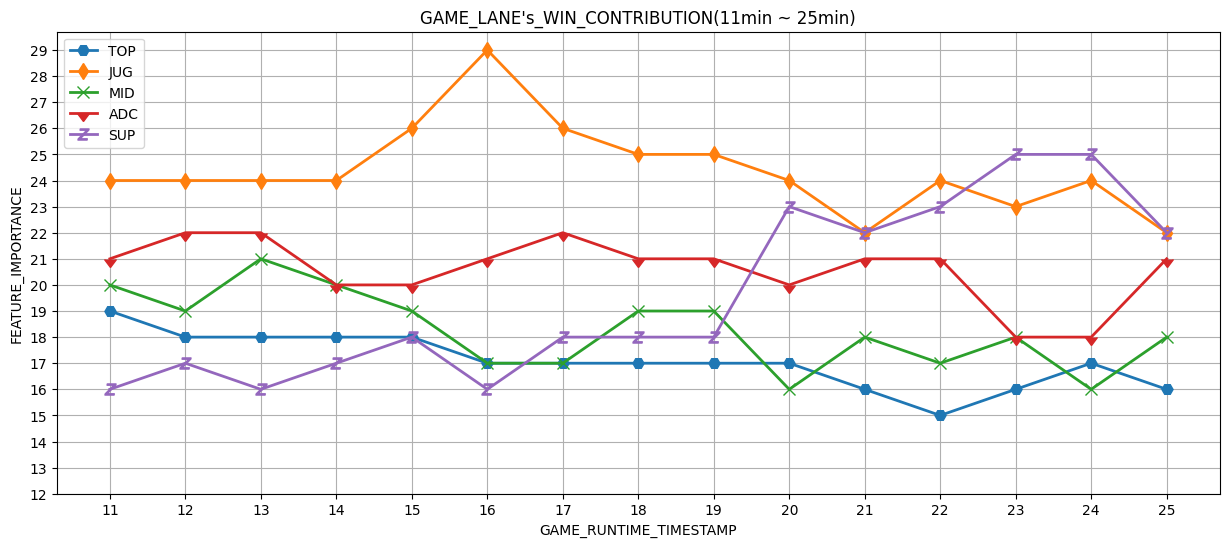

In [462]:
feature_importance_2d_array = []

for time in range(11,26):
    feature_importance_2d_array.append(get_lane_importance(time))

np.array(feature_importance_2d_array).T
result = np.array(feature_importance_2d_array).T

## plot 
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

plt.plot(range(11,26),result[0], marker="H"   ,markersize=8 ,linewidth='2')
plt.plot(range(11,26),result[1], marker="d"   ,markersize=8 ,linewidth='2')
plt.plot(range(11,26),result[2], marker="x"   ,markersize=8 ,linewidth='2')
plt.plot(range(11,26),result[3], marker=11    ,markersize=8 ,linewidth='2')
plt.plot(range(11,26),result[4], marker='$Z$' ,markersize=8 ,linewidth='2')

plt.title("GAME_LANE's_WIN_CONTRIBUTION(11min ~ 25min)")
plt.ylabel("FEATURE_IMPORTANCE")
plt.xlabel("GAME_RUNTIME_TIMESTAMP")
plt.xticks(range(11,26))
plt.yticks(range(12,30))
plt.grid(visible=True)
plt.legend(['TOP','JUG','MID','ADC','SUP'] , loc='upper left')
plt.show()

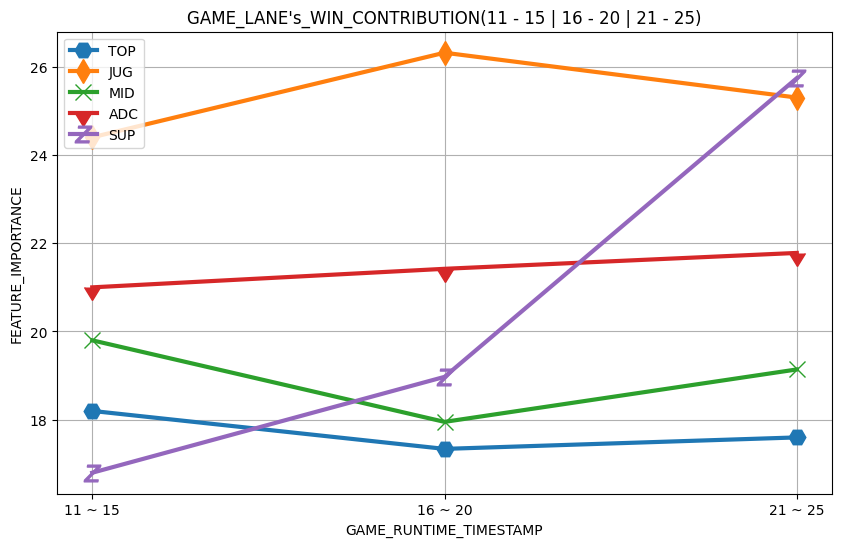

In [463]:
def five_min_mean(arr):
    return [np.mean(arr[0:5]),1.02*np.mean(arr[5:10]),1.1*np.mean(arr[10:15])]

## plot 
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(['11 ~ 15', '16 ~ 20', '21 ~ 25'],five_min_mean(result[0]), marker="H"   ,markersize=12 ,linewidth='3')
plt.plot(['11 ~ 15', '16 ~ 20', '21 ~ 25'],five_min_mean(result[1]), marker="d"   ,markersize=12 ,linewidth='3')
plt.plot(['11 ~ 15', '16 ~ 20', '21 ~ 25'],five_min_mean(result[2]), marker="x"   ,markersize=12 ,linewidth='3')
plt.plot(['11 ~ 15', '16 ~ 20', '21 ~ 25'],five_min_mean(result[3]), marker=11    ,markersize=12 ,linewidth='3')
plt.plot(['11 ~ 15', '16 ~ 20', '21 ~ 25'],five_min_mean(result[4]), marker='$Z$' ,markersize=12 ,linewidth='3')

plt.title("GAME_LANE's_WIN_CONTRIBUTION(11 - 15 | 16 - 20 | 21 - 25)")
plt.ylabel("FEATURE_IMPORTANCE")
plt.xlabel("GAME_RUNTIME_TIMESTAMP")
#plt.yticks(range(12,30))
plt.grid(visible=True)
plt.legend(['TOP','JUG','MID','ADC','SUP'] , loc='upper left')
plt.show()

In [382]:
T,J,M,A,S = [],[],[],[],[]

for t in range(11,26):
    df = pd.read_csv(rf'{DIR}\MASTER_TIMELINE_DATA_TIMESTAMP_{t}_MIN_R.csv')

    T.append((df['100*PROB_GAP'] / df['TOP_GAP']).mean())
    J.append((df['100*PROB_GAP'] / df['JUG_GAP']).mean())
    M.append((df['100*PROB_GAP'] / df['MID_GAP']).mean())
    A.append((df['100*PROB_GAP'] / df['ADC_GAP']).mean())
    S.append((df['100*PROB_GAP'] / df['SUP_GAP']).mean())


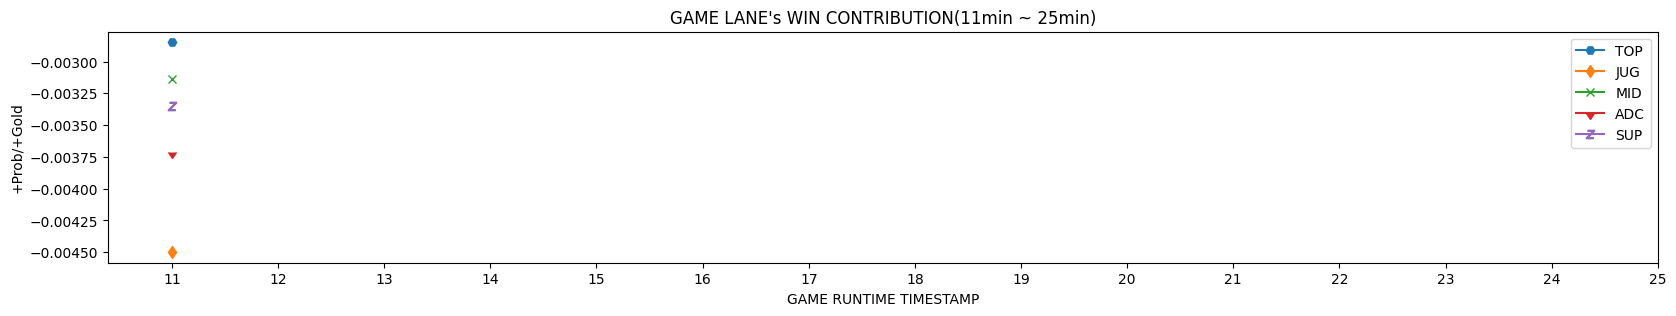

In [383]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,3))

plt.plot(range(11,26),T, marker="H")
plt.plot(range(11,26),J, marker="d")
plt.plot(range(11,26),M, marker="x")
plt.plot(range(11,26),A, marker=11)
plt.plot(range(11,26),S, marker='$Z$')

plt.title("GAME LANE's WIN CONTRIBUTION(11min ~ 25min)")
plt.ylabel("+Prob/+Gold")
plt.xlabel("GAME RUNTIME TIMESTAMP")
plt.xticks(range(11,26))
plt.legend(['TOP','JUG','MID','ADC','SUP'])
plt.show()

In [384]:
#### 기여도를 RANK 로 변환 숫자가 높을 수록 중요도 높음

import numpy as np
def RANKING(T,J,M,A,S):

    # Combine lists into a 2D numpy array
    data = np.array([T,J,M,A,S])

    # Transpose to align same-index elements on the same row
    data = data.T

    # Apply argsort twice to get rank. Higher numbers get higher ranks.
    ranked_lists = data.argsort().argsort()
    ranked_lists += 1
    # Transpose again to get back to original structure
    ranked_lists = ranked_lists.T

    # Split into separate lists
    T = ranked_lists[0].tolist()
    J = ranked_lists[1].tolist()
    M = ranked_lists[2].tolist()
    A = ranked_lists[3].tolist()
    S = ranked_lists[4].tolist()

    return T,J,M,A,S  

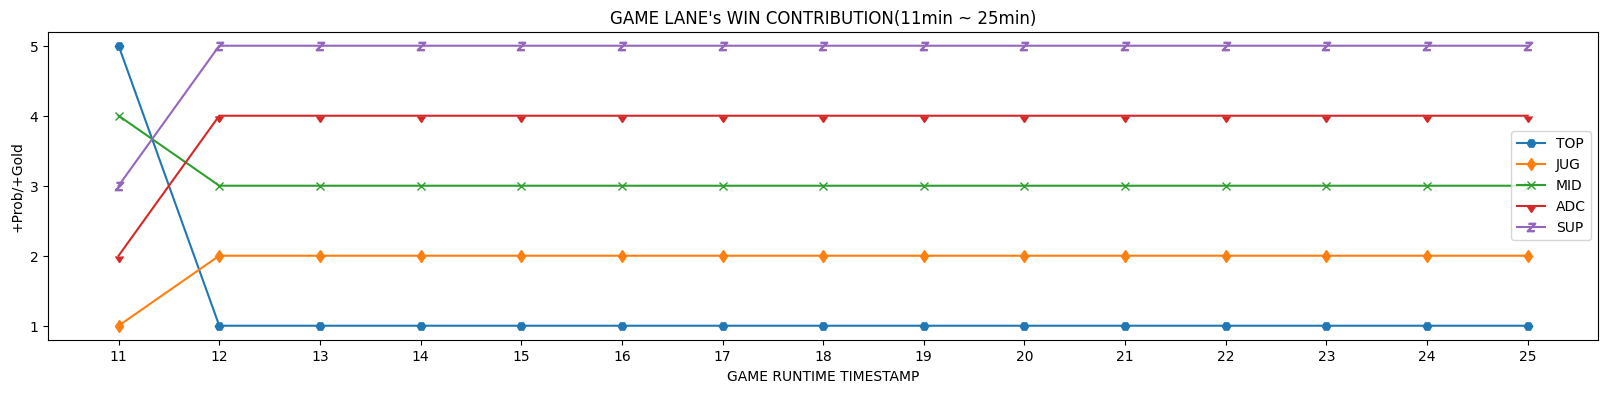

In [385]:
import matplotlib.pyplot as plt

T,J,M,A,S = RANKING(T,J,M,A,S)

plt.figure(figsize=(20,4))

plt.plot(range(11,26),T, marker="H")
plt.plot(range(11,26),J, marker="d")
plt.plot(range(11,26),M, marker="x")
plt.plot(range(11,26),A, marker=11)
plt.plot(range(11,26),S, marker='$Z$')

plt.title("GAME LANE's WIN CONTRIBUTION(11min ~ 25min)")
plt.ylabel("+Prob/+Gold")
plt.xlabel("GAME RUNTIME TIMESTAMP")
plt.xticks(range(11,26))
plt.yticks(range(1,6))
plt.legend(['TOP','JUG','MID','ADC','SUP'])
plt.show()

<BarContainer object of 5 artists>

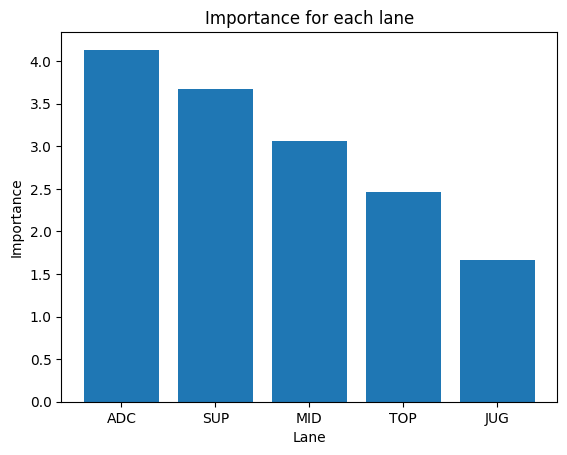

In [337]:
plt.title("Importance for each lane")
plt.ylabel("Importance")
plt.xlabel("Lane")
plt.bar(['ADC','SUP','MID','TOP','JUG'],[np.mean(A) , np.mean(S) , np.mean(M) , np.mean(T) , np.mean(J)])

In [137]:
results[15]

array([0.9977423], dtype=float32)

In [108]:
results

[0.2953088581562042, 0.8558209538459778]

In [15]:
'''from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_normalized, labels, test_size=0.2, random_state=42)

# define the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# train the model
model.fit(X_train, y_train)

# make predictions on the test set
predictions = model.predict(X_test)

# calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)

# print the accuracy
print(f'Accuracy: {accuracy * 100}%')

# print the confusion matrix
print(confusion_matrix(y_test, predictions))'''

KeyboardInterrupt: 